# ДЗ 1 (ОБЯЗАТЕЛЬНОЕ): Анализ температурных данных и мониторинг текущей температуры через OpenWeatherMap API

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Анализ исторических данных

In [ ]:
temperature_data = pd.read_csv("./temperature_data.csv")

### Проверка данных

Следует убедиться, что timestamp приведен к типу datetime

In [ ]:
temperature_data.head()

,city,timestamp,temperature,season
0,New York,2010-01-01,6.789716,winter
1,New York,2010-01-02,-9.569202,winter
2,New York,2010-01-03,7.696058,winter
3,New York,2010-01-04,0.958770,winter
4,New York,2010-01-05,1.219530,winter


In [ ]:
temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


timestamp типа object, следовательно, нужно привести его к datetime

In [ ]:
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])

In [ ]:
temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   city         54750 non-null  object        
 1   timestamp    54750 non-null  datetime64[ns]
 2   temperature  54750 non-null  float64       
 3   season       54750 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.7+ MB


### Вычисление дополнительных данных

Следует написать функцию, которая сможет:
- Вычислить **скользящее среднее** температуры с окном в 30 дней для сглаживания краткосрочных колебаний.
- Рассчитать среднюю температуру и стандартное отклонение для каждого сезона в каждом городе.
- Выявить аномалии, где температура выходит за пределы $ \text{среднее} \pm 2\sigma $.

In [ ]:
def process_data(data):
    data['rolling_mean'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())
    data['rolling_std'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())
    data['lower_bound'] = data['rolling_mean'] - 2 * data['rolling_std']
    data['upper_bound'] = data['rolling_mean'] + 2 * data['rolling_std']
    data['anomaly_temperature'] = (data['temperature'] < data['lower_bound']) | (data['temperature'] > data['upper_bound'])
    return data

#### Проверка работы без распараллеливания

In [ ]:
default_processed_data = temperature_data.copy()
start_time = time.time()
process_data(default_processed_data)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.047365427017211914


#### Проверка с распараллеливанием

1) С использованием библиотеки modin

In [ ]:
! pip install "modin[ray]" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00


In [ ]:
import modin.pandas as mpd

modin_processed_data = mpd.DataFrame(temperature_data)
start_time = time.time()
process_data(modin_processed_data)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.33873558044433594


2) С использованием multiprocessing

In [ ]:
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor

grouped_data = temperature_data.groupby(['city', 'season'])
chunks = [pd.DataFrame(group[1]) for group in grouped_data]
start_time = time.time()
with ProcessPoolExecutor() as executor:
    results = executor.map(process_data, chunks)
pd.concat(results)
print(f"Выполнено за {time.time() - start_time}")

Выполнено за 0.699282169342041


**Вывод:** Обычные операции с DataFrame без распараллеливания работают быстрее

### Графики с отображением температуры по городам

На графиках отображены температура, скользящее среднее с окном в 30 дней и аномалии.  
Аномалии отображены красными точками на графиках

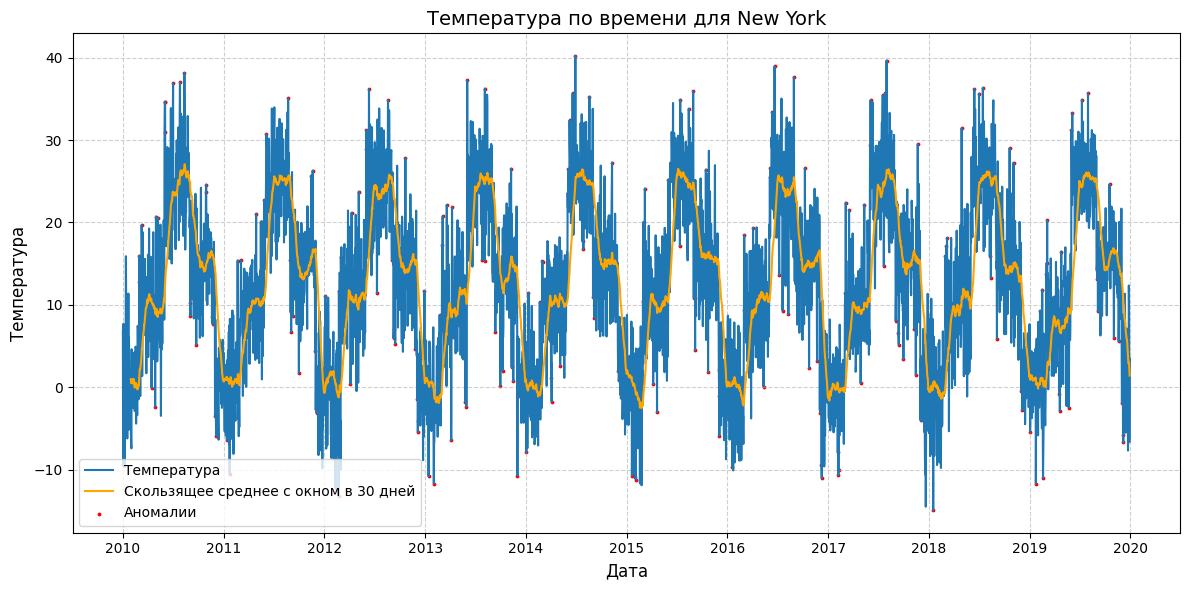

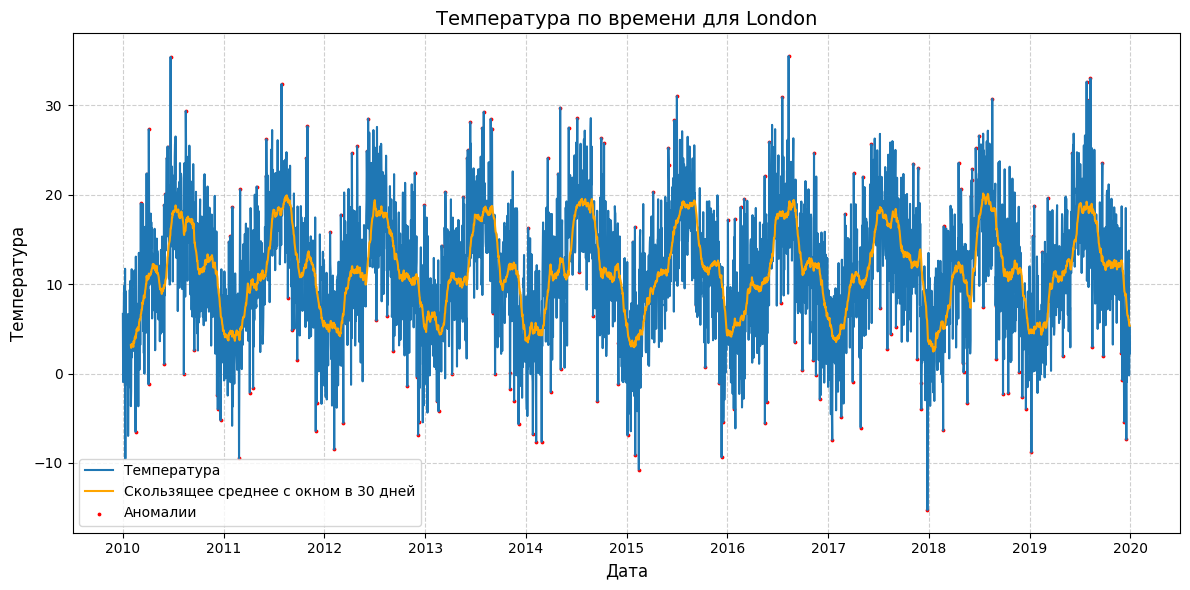

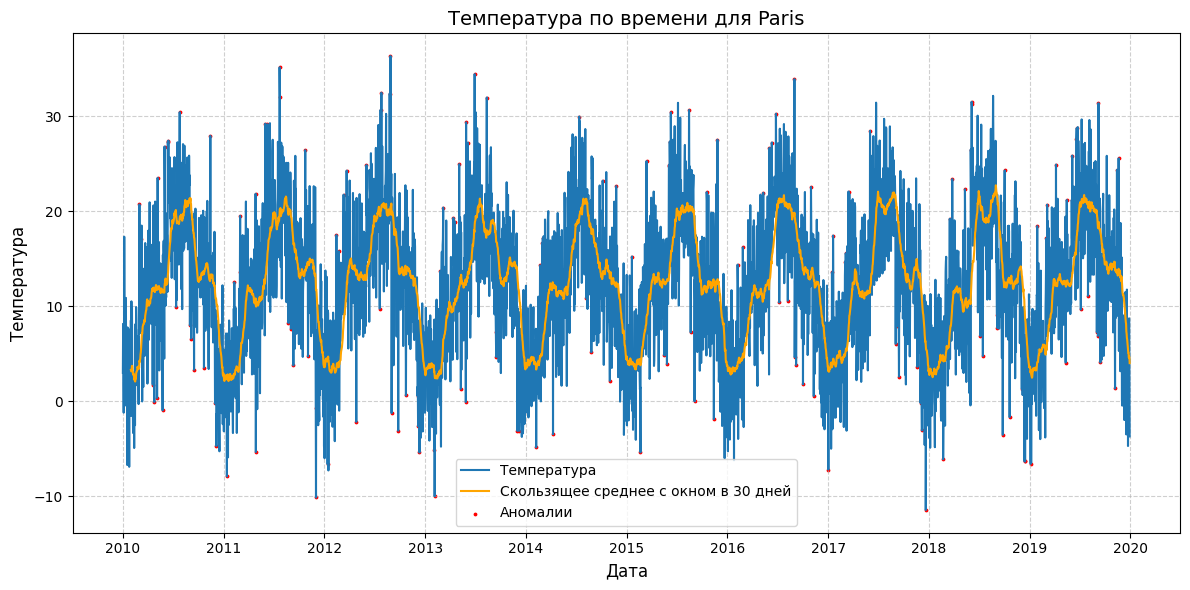

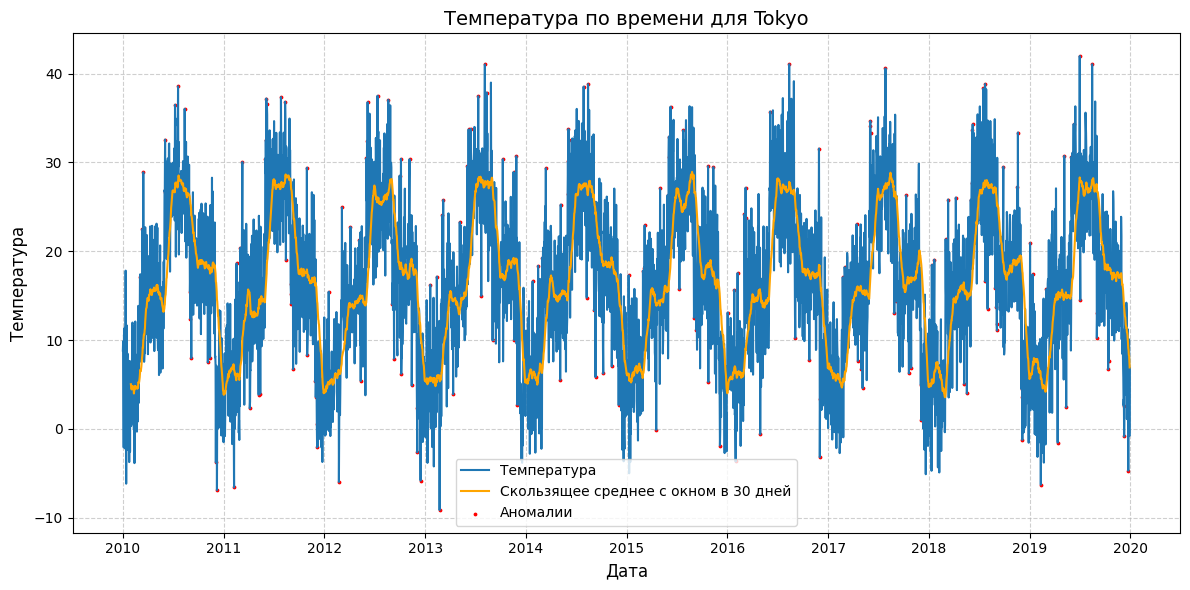

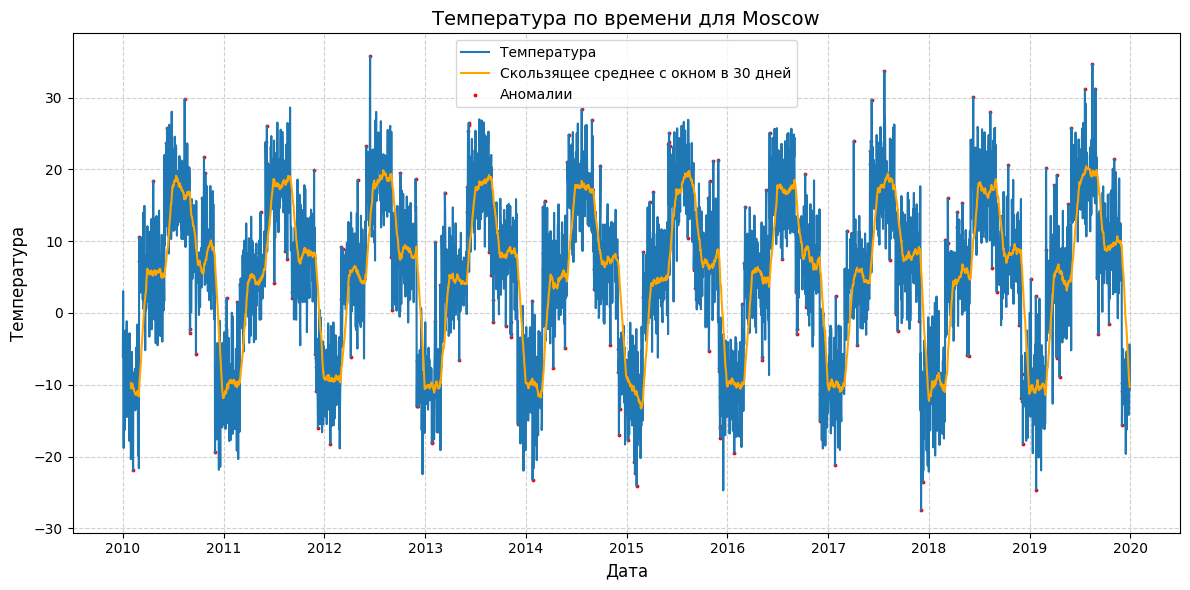

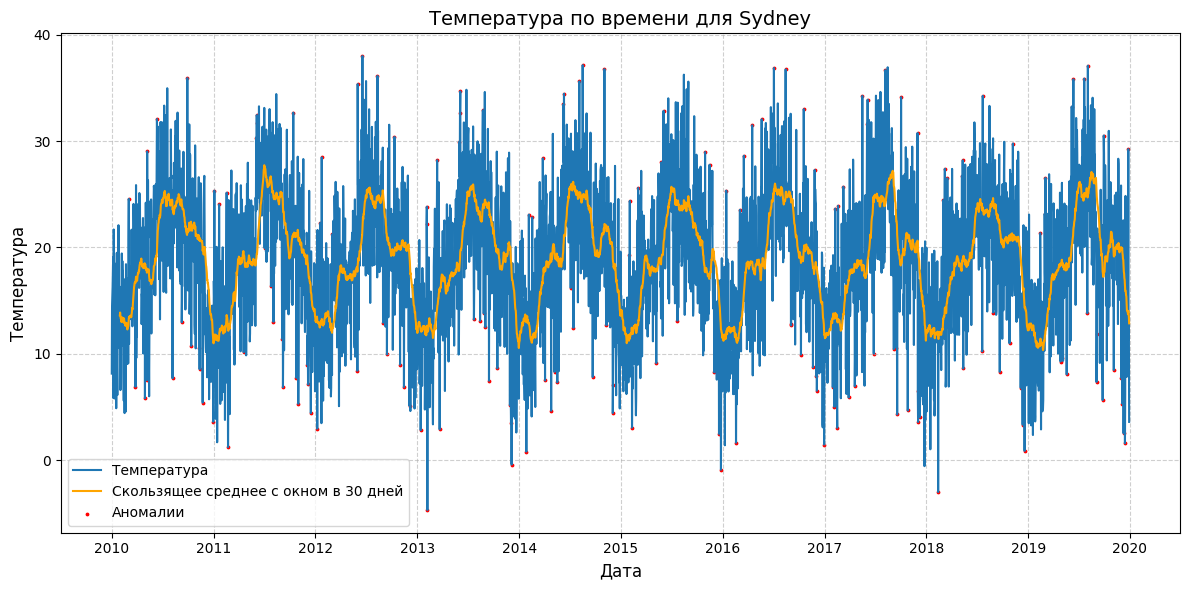

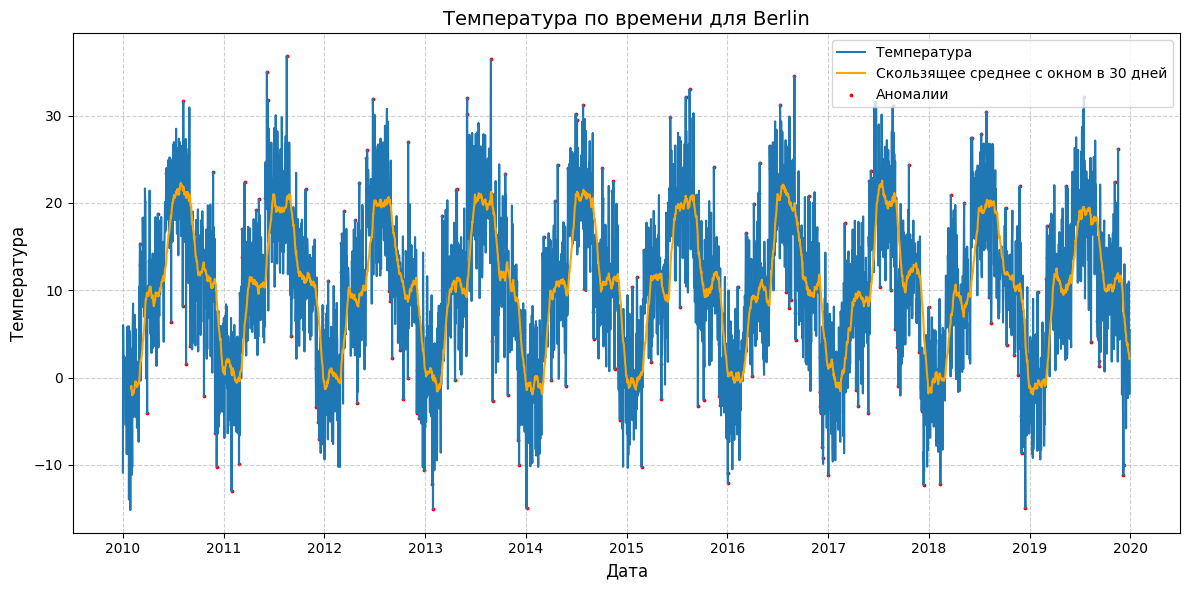

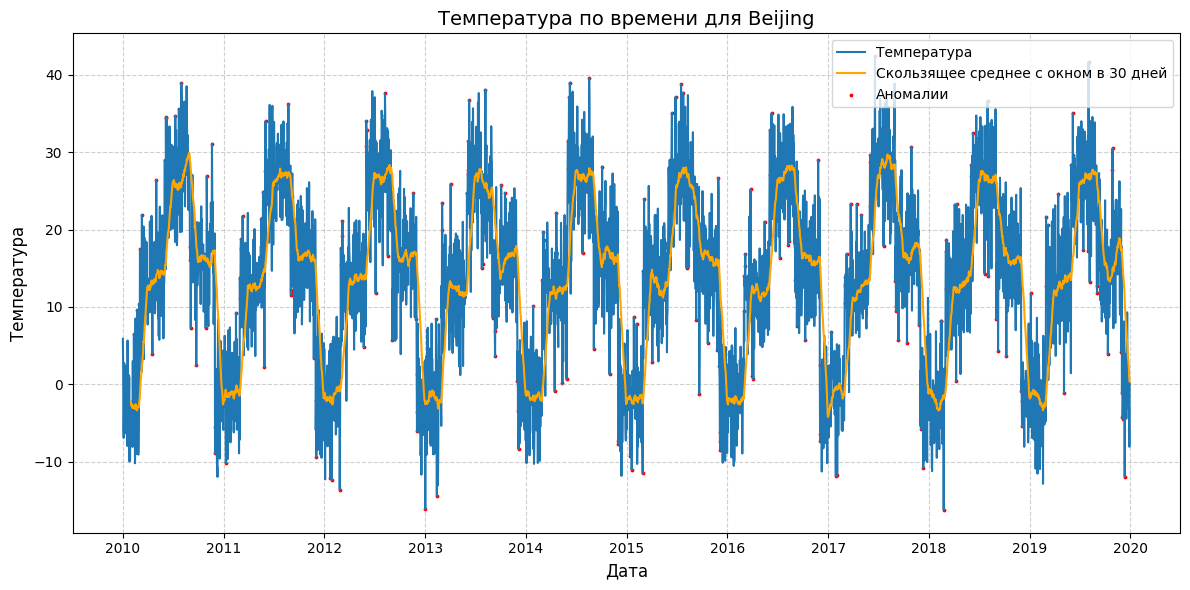

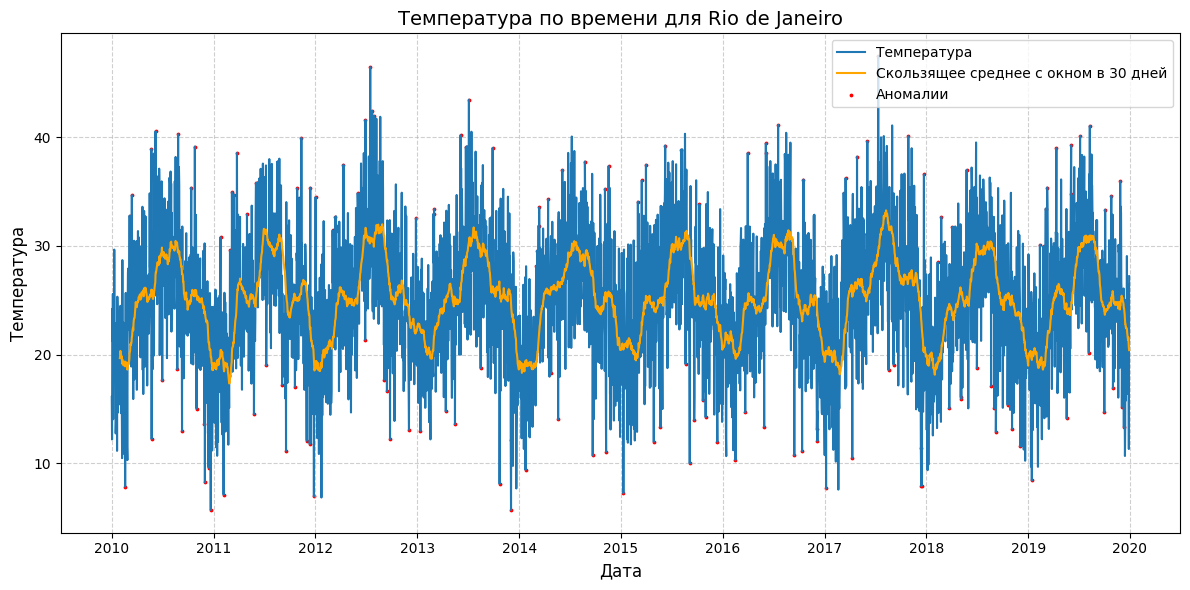

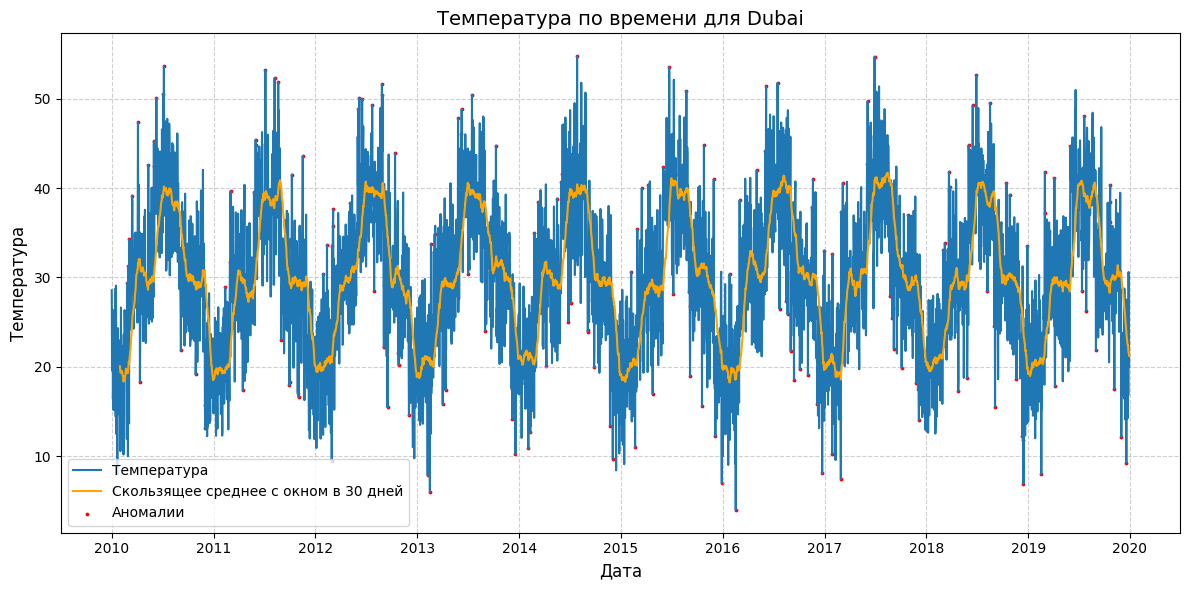

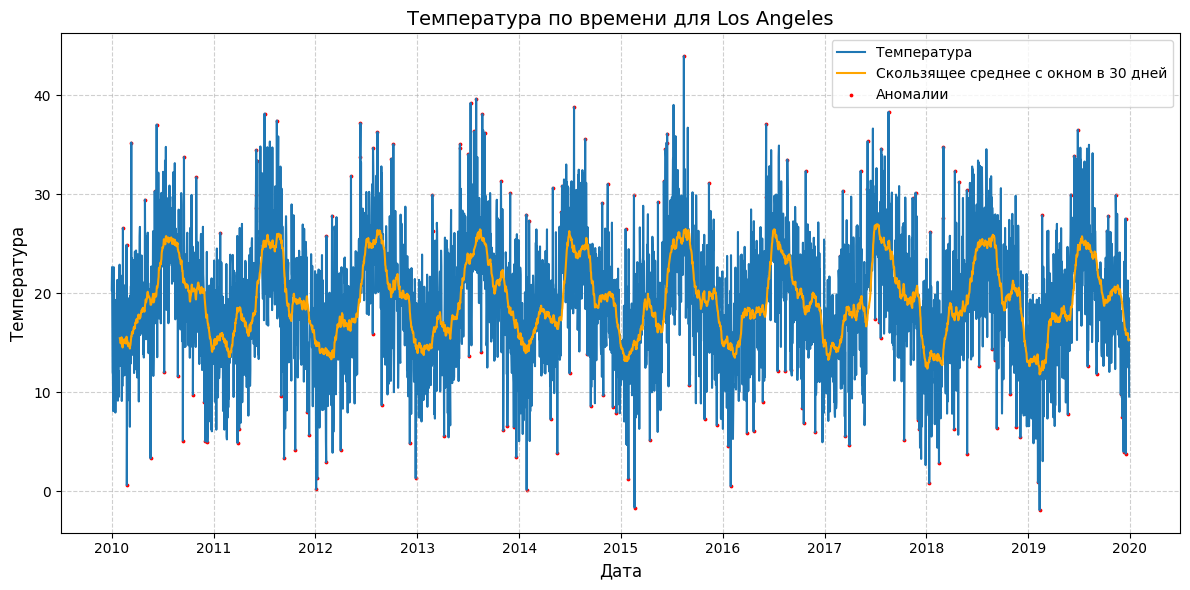

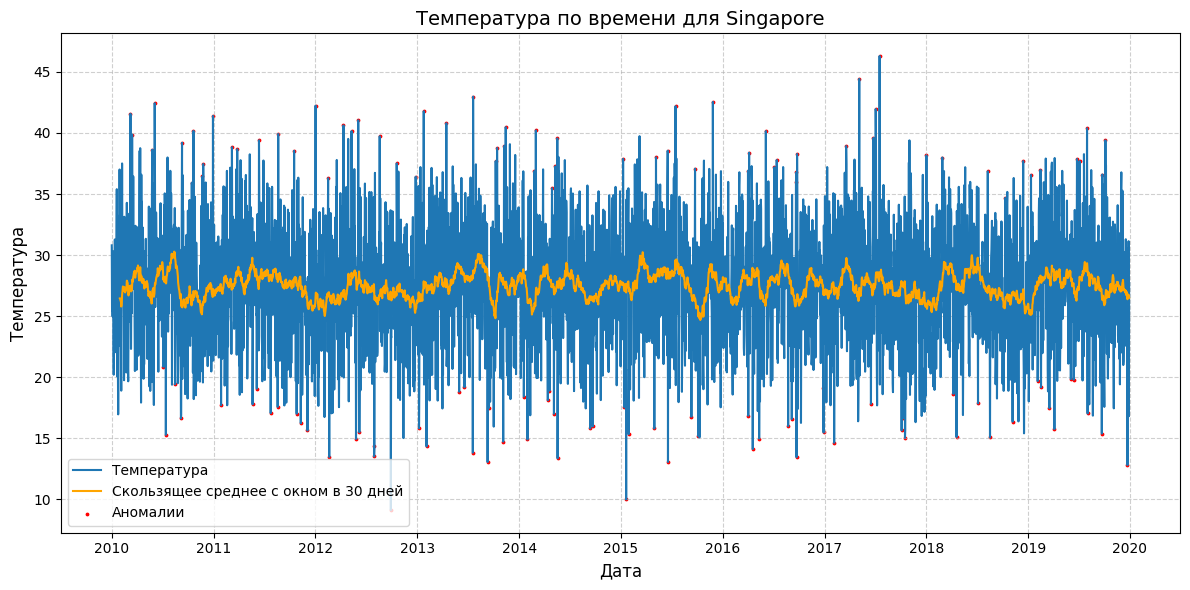

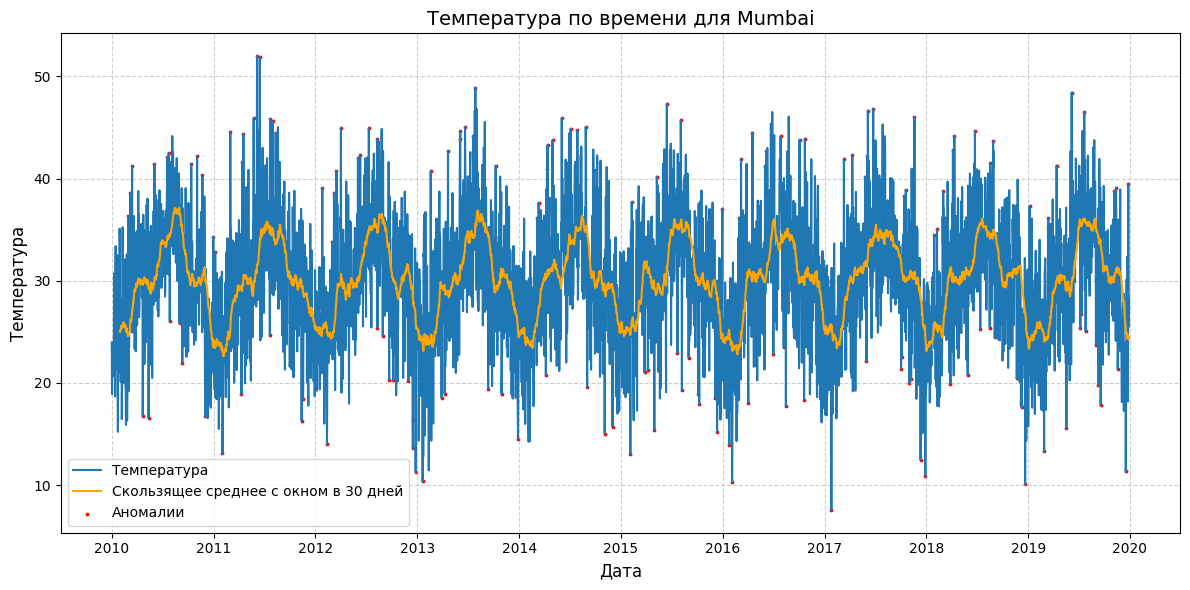

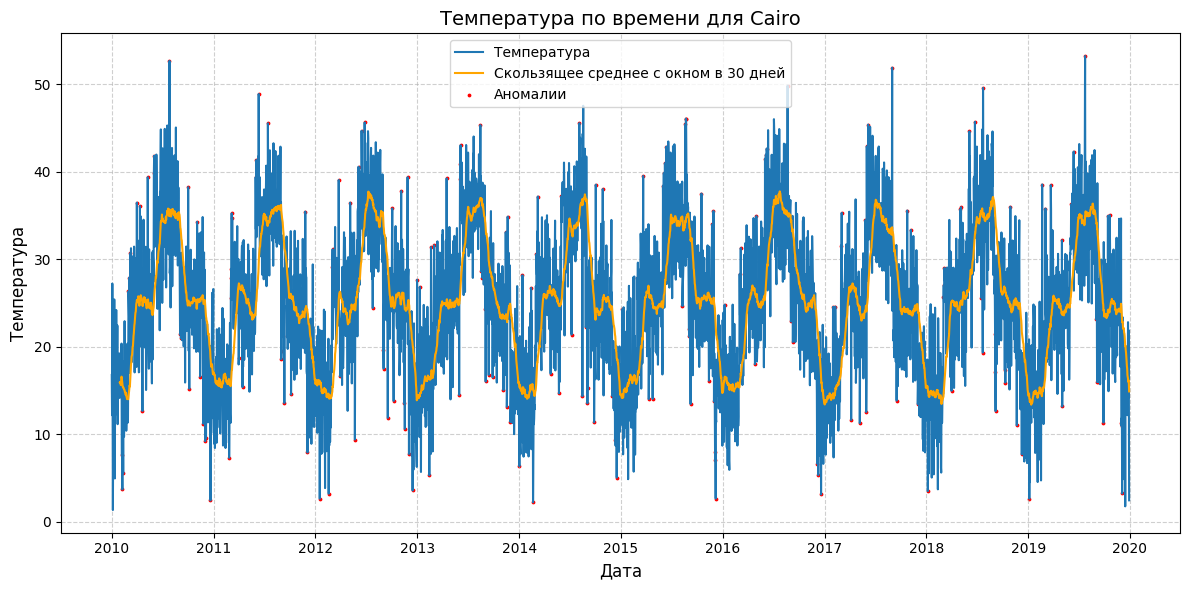

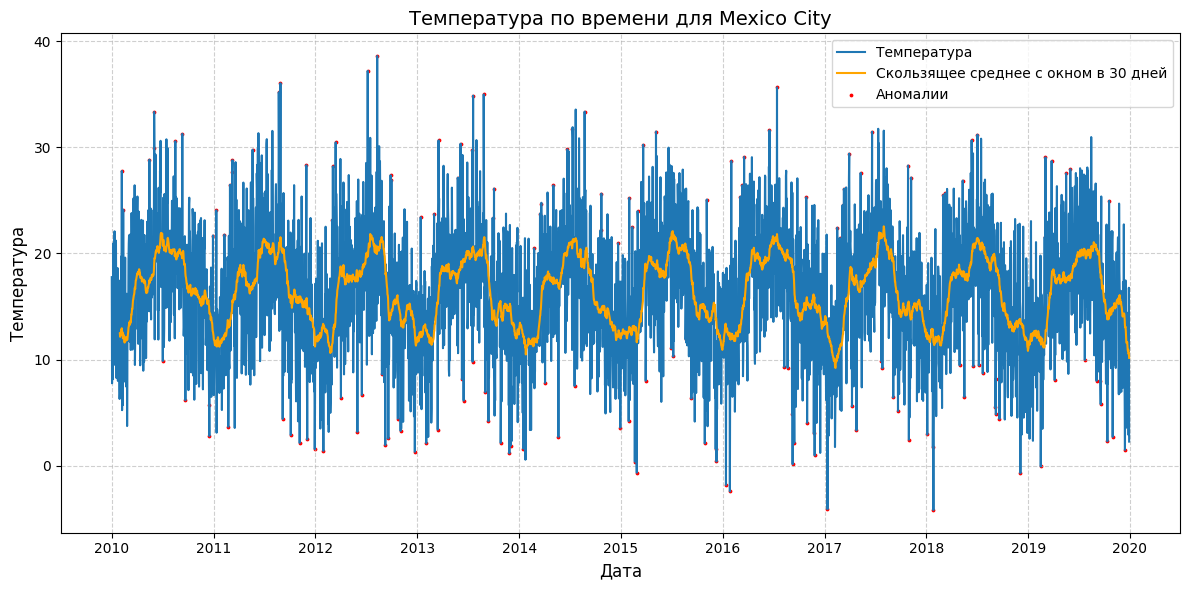

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(data, city):
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['temperature'], label='Температура')
    plt.plot(data['timestamp'], data['rolling_mean'], label='Скользящее среднее с окном в 30 дней', color='orange')
    plt.scatter(data[city_data['anomaly_temperature'] == True]['timestamp'], data[city_data['anomaly_temperature'] == True]['temperature'], s=3, c='red', label='Аномалии')

    plt.title(f'Температура по времени для {city}', fontsize=14)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Температура', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

cities = default_processed_data['city'].unique()
for city in cities:
    city_data = default_processed_data[default_processed_data['city'] == city]
    plot_time_series(city_data, city)

In [ ]:
from getpass import getpass

print("Введите ключ OpenWeatherMap API:\n")
API_KEY = getpass()

Введите ключ OpenWeatherMap API:

··········


## Мониторинг текущей температуры:

**Следует проверить, какой запрос будет выполняться быстрее синхронный или асинсхронный**.  
Проверять буду получая погоду для Москвы и Токио

In [ ]:
URL = "https://api.openweathermap.org/"

In [ ]:
import aiohttp
import asyncio

async def get_data_async(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as resp:
            return await resp.json()

In [ ]:
async def get_weather_async(city):
    coords_url = URL+f"geo/1.0/direct?q={city}&appid={API_KEY}"
    coords = await get_data_async(coords_url)
    lat, lon = coords[0]['lat'], coords[0]['lon']
    weather_url = URL+f"data/2.5/weather?lat={lat}&lon={lon}&units=metric&appid={API_KEY}"
    weather = await get_data_async(weather_url)
    return f"Температура в городе {coords[0]['local_names']['ru']}: {weather['main']['temp']}"

#### Проверка асинхронных запросов

In [ ]:
start_time = time.time()
result = await asyncio.gather(get_weather_async("Moscow"), get_weather_async("Tokyo"))
print(f"Выполнено за {time.time()-start_time}")
print(result)

Выполнено за 0.4738776683807373
['Температура в городе Москва: -6.73', 'Температура в городе Токио: 4.42']


#### Проверка синхронных запросов

In [ ]:
start_time = time.time()
result = [await get_weather_async(city) for city in ["Moscow", "Tokyo"]]
print(f"Выполнено за {time.time()-start_time}")
print(result)

Выполнено за 0.6213209629058838
['Температура в городе Москва: -6.73', 'Температура в городе Токио: 4.42']


**Вывод: Асинхронные запросы работают быстрее.**  
Это происходит из-за того, что приложению не приходится ждать завершения предыдущего запроса для начала выполнения следующего